### Pseudo Labelling + Lasso + Gaussian Mixture + PCA + QDA

This notebook is a merge of  [Pseudo labelling with PCA-QDA](http://https://www.kaggle.com/rdekou/pseudo-labelling-with-pca-qda) and [GraphicalLasso + GaussianMixture](http://https://www.kaggle.com/christofhenkel/graphicallasso-gaussianmixture). Thanks to the original authors for their work. First QDA model is replaced with Lasso and Gaussian Mixture which slightly boosts the score on the LB.


## Load Data

In [1]:
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import GraphicalLasso
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture


train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [2]:
def get_mean_cov(x,y):
    model = GraphicalLasso()
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps


In [3]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        
        gm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
        gm.fit(np.concatenate([train3,test3],axis = 0))
        oof[idx1[test_index]] = gm.predict_proba(train3[test_index,:])[:,0]
        preds[idx2] += gm.predict_proba(test3)[:,0] / skf.n_splits

        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))


  0%|          | 0/512 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.327e-04
  % (max_iter, d_gap), ConvergenceWarning)
 13%|█▎        | 68/512 [02:42<17:04,  2.31s/it]/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.271e-04
  % (max_iter, d_gap), ConvergenceWarning)
 16%|█▌        | 80/512 [03:08<15:10,  2.11s/it]/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.834e-04
  % (max_iter, d_gap), ConvergenceWarning)
 19%|█▉        | 97/512 [03:49<15:51,  2.29s/it]/opt/conda/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.

QDA scores CV = 0.96749


In [4]:
cat_dict = dict()

# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')

for i in range(512):

    
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    
    
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    cat_dict[i] = train3.shape[1]


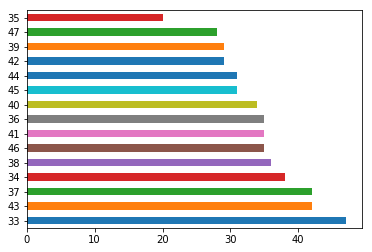

In [5]:
pd.DataFrame(list(cat_dict.items()))[1].value_counts().plot.barh()


# Add pseudo label data from PCA-QDA and run a new model Variance-QDA

In [6]:

# INITIALIZE VARIABLES
test['target'] = preds
oof_var = np.zeros(len(train))
preds_var = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for k in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    
    # ADD PSEUDO LABELED DATA
    test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    
  
    
    pca = PCA(n_components=cat_dict[k], random_state= 1234)
    pca.fit(train2p[cols])
    train3p = pca.transform(train2p[cols])
    train3 = pca.transform(train2[cols])
    test3 = pca.transform(test2[cols])

           
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof_var[idx1[test_index3]] += clf.predict_proba(train3[test_index3,:])[:,1]
        preds_var[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits
       
       
    #if k%64==0: print(k)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof_var)
print('Pseudo Labeled QDA scores CV =',round(auc,5)) #0.97035


Pseudo Labeled QDA scores CV = 0.96918


In [7]:
# INITIALIZE VARIABLES
test['target'] = preds_var  
oof_var2 = np.zeros(len(train))
preds_var2 = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for k in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    
    # ADD PSEUDO LABELED DATA
    test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    
    
    
       
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
           
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof_var2[idx1[test_index3]] += clf.predict_proba(train3[test_index3,:])[:,1]
        preds_var2[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits
       
       
    #if k%64==0: print(k)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof_var2)
print('Pseudo Labeled QDA scores CV =',round(auc,5))

Pseudo Labeled QDA scores CV = 0.96964


# Final model accuracy

In [8]:
auc = roc_auc_score(train['target'],0.5*(oof_var+ oof_var2) )
print('Pseudo Labeled QDA scores CV =',round(auc,5))

Pseudo Labeled QDA scores CV = 0.96959


# Submit Predictions

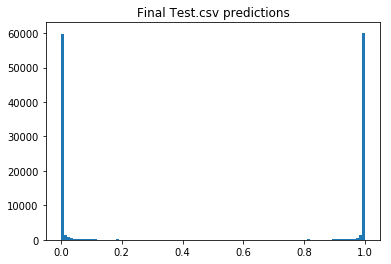

In [9]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = 0.5* preds_var + 0.5*preds_var2
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()